<a href="https://colab.research.google.com/github/Shubhangidharmik/Product-Recommendation-Engine/blob/main/4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Build a recommender engine that reviews customer ratings and purchase history to recommend items and improve sales. </u></b>

### Amazon.com is one of the largest electronic commerce and cloud computing companies.

### Just a few Amazon related facts:

### They lost $4.8 million in August 2013, when their website went down for 40 mins. They hold the patent on 1-Click buying, and licenses it to Apple. Their Phoenix fulfilment centre is a massive 1.2 million square feet. Amazon relies heavily on a Recommendation engine that reviews customer ratings and purchase history to recommend items and improve sales.


### This is a dataset related to over 2 Million customer reviews and ratings of Beauty related products sold on their website.

### It contains

* ### the unique UserId (Customer Identification),
* ### the product ASIN (Amazon's unique product identification code for each product),
* ### Ratings (ranging from 1-5 based on customer satisfaction) and
* ### the Timestamp of the rating (in UNIX time)

### This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.

### This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs).


In [ ]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Product recommendation Engine/Copy of ratings_Beauty.csv')
df.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [ ]:
df.shape

(2023070, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


# **Data Cleaning**

In [ ]:
df.describe()

,Rating,Timestamp
count,2.023070e+06,2.023070e+06
mean,4.149036e+00,1.360389e+09
std,1.311505e+00,4.611860e+07
min,1.000000e+00,9.087552e+08
25%,4.000000e+00,1.350259e+09
50%,5.000000e+00,1.372810e+09
75%,5.000000e+00,1.391472e+09
max,5.000000e+00,1.406074e+09


In [ ]:
df.isnull().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

**Dropping the "Timestamp" column**

In [ ]:
df.drop('Timestamp', inplace = True, axis = 1)

In [ ]:
df.head(2)

,UserId,ProductId,Rating
0,A39HTATAQ9V7YF,0205616461,5.0
1,A3JM6GV9MNOF9X,0558925278,3.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
dtypes: float64(1), object(2)
memory usage: 46.3+ MB


**The data is very big So we will consider first 50000 rows and all columns from dataset.**

In [ ]:
#Taking subset of the dataset
df1=df.iloc[:50000,0:]

In [ ]:
df1.head(3)

,UserId,ProductId,Rating
0,A39HTATAQ9V7YF,0205616461,5.0
1,A3JM6GV9MNOF9X,0558925278,3.0
2,A1Z513UWSAAO0F,0558925278,5.0


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   UserId     50000 non-null  object 
 1   ProductId  50000 non-null  object 
 2   Rating     50000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
df1.describe()

,Rating
count,50000.000000
mean,4.159460
std,1.321525
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


**Detecting NULL values**

In [ ]:
df1.isnull().sum()

UserId       0
ProductId    0
Rating       0
dtype: int64

# **Exploratory Data Analysis**

In [ ]:
df1['Rating'].value_counts()

5.0    31403
4.0     7324
1.0     4722
3.0     3838
2.0     2713
Name: Rating, dtype: int64

Text(0.5, 1.0, 'Rating of the product')

Text(0.5, 0, 'Rating')

Text(0, 0.5, 'Frequency')

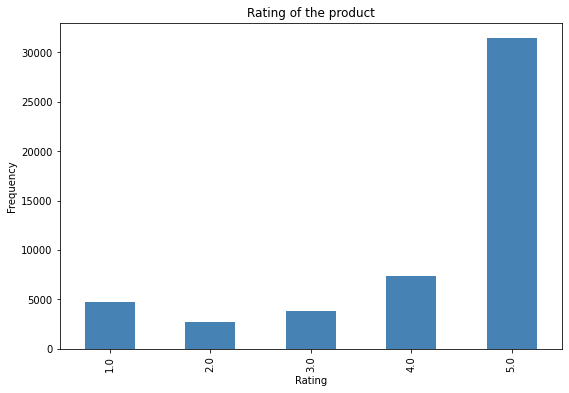

In [ ]:
counts = df1['Rating'].value_counts().sort_index()
fig = plt.figure(figsize=(9, 6))
ax = fig.gca()
counts.plot.bar(ax = ax, color='steelblue')
ax.set_title('Rating of the product')
ax.set_xlabel('Rating') 
ax.set_ylabel("Frequency")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


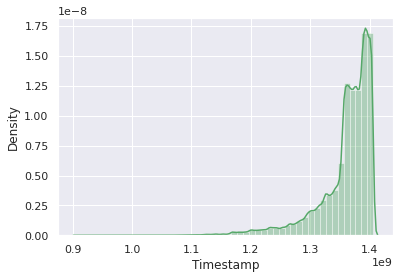

In [ ]:
sns.distplot(df['Timestamp'], color='g')

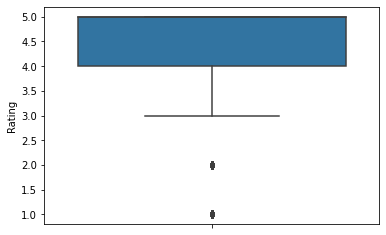

In [ ]:
sns.boxplot(y='Rating',data=df)

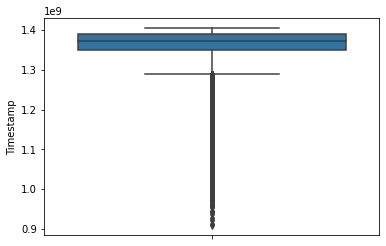

In [ ]:
sns.boxplot(y='Timestamp',data=df)

In [ ]:
counts=df['UserId'].value_counts()
df1=df[df['UserId'].isin(counts[counts>=50].index)]
df1.head(30)

,UserId,ProductId,Rating,Timestamp
5,AKJHHD5VEH7VG,0762451459,5.0,1404518400
42,A22ZFXQE8AWPEP,1304482596,1.0,1383177600
47,A22ZFXQE8AWPEP,1304482685,1.0,1383177600
52,A22ZFXQE8AWPEP,1304495396,1.0,1384992000
61,A22ZFXQE8AWPEP,1304511111,1.0,1384992000
66,A22ZFXQE8AWPEP,1304511138,1.0,1384992000
86,A22ZFXQE8AWPEP,1304622665,1.0,1386028800
87,A22ZFXQE8AWPEP,1304624498,1.0,1385683200
92,A22ZFXQE8AWPEP,1304651029,1.0,1386028800
102,A22ZFXQE8AWPEP,130466578X,1.0,1386028800


**Popularity based on product rating**

In [ ]:
products_df = pd.DataFrame(df1.groupby('ProductId')['Rating'].mean())
products_df['product_rating_counts'] = pd.DataFrame(df1.groupby('ProductId')['Rating'].count())
products_df.head()

,Rating,product_rating_counts
ProductId,,
0762451459,5.0,1
1304482596,1.0,1
1304482685,1.0,1
1304495396,1.0,1
1304511111,1.0,1


In [ ]:
products_df.sort_values('Rating', ascending=False).head()

,Rating,product_rating_counts
ProductId,,
0762451459,5.0,1
B004JAZGOC,5.0,1
B004ITB3IW,5.0,6
B004ITYX52,5.0,1
B004IVM0EG,5.0,1


In [ ]:
products_df.sort_values('product_rating_counts', ascending=False).head()

,Rating,product_rating_counts
ProductId,,
B009FKNGGQ,3.816667,60
B00AE0790U,4.140351,57
B009FKNGRA,4.340426,47
B00AO4EBOI,4.152174,46
B008U2Y9BQ,4.108696,46


**Popularity based on User rating**

In [ ]:
users_df = pd.DataFrame(df1.groupby('UserId')['Rating'].mean())
users_df['user_rating_counts'] = pd.DataFrame(df1.groupby('UserId')['Rating'].count())
users_df.head()

,Rating,user_rating_counts
UserId,,
A100WO06OQR8BQ,3.592593,54
A1047EDJ84IMAS,4.317073,82
A10G136JEISLVR,3.426471,68
A10Y59HW4O47N0,4.711538,52
A110PQTEI6THU7,3.196429,56


In [ ]:
users_df.sort_values('Rating', ascending=False).head()

,Rating,user_rating_counts
UserId,,
AJGU56YG8G1DQ,5.000000,130
AAEVYY0PHQUUL,5.000000,60
A135SX8ESCQV9B,5.000000,52
ALEW5AUKCRWHN,5.000000,55
A1Q1Z7IR79G52A,4.985507,69


In [ ]:
users_df.sort_values('user_rating_counts', ascending=False).head()

,Rating,user_rating_counts
UserId,,
A3KEZLJ59C1JVH,3.704370,389
A281NPSIMI1C2R,4.791667,336
A3M174IC0VXOS2,4.414110,326
A2V5R832QCSOMX,4.417266,278
A3LJLRIZL38GG3,4.550725,276


In [ ]:
# Number of unique user id  in the data
print('Number of unique users = ', df1['UserId'].nunique())
# Number of unique product id  in the data
print('Number of unique product = ', df1['ProductId'].nunique())

Number of unique users =  47017
Number of unique product =  2581


In [ ]:
#Check the top 10 users based on ratings
most_rated=df1.groupby('UserId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 UserId
A281NPSIMI1C2R    42
A1Z54EM24Y40LL    25
A3M174IC0VXOS2    22
AK7CAW3N1XZV6     15
AKMEY1BSHSDG7     14
A1BG8QW55XHN6U    13
A2B7BUH8834Y6M    11
A1IU7S4HCK1XK0    10
A22ZFXQE8AWPEP     9
A132ETQPMHQ585     9
dtype: int64


In [ ]:
counts= df1.UserId.value_counts()
df1_final= df1[df1.UserId.isin(counts[counts>=15].index)]
print('Number of users who have rated 15 or more items =', len(df1_final))
print('Number of unique users in final data = ', df1_final['UserId'].nunique())
print('Number of unique products in final data = ', df1_final['UserId'].nunique())

Number of users who have rated 15 or more items = 104
Number of unique users in final data =  4
Number of unique products in final data =  4


# **Rating Analysis**

In [ ]:
#constructing the pivot table and draw sparse matrix
final_ratings_matrix = df1_final.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
final_ratings_matrix.head()

ProductId,B00000JGVX,B000050B6X,B000050FET,B000052WYL,B000052Y1Q,B000052Y33,B000052YJX,B000052YJY,B000052YKU,B000052YM7,B000052YMQ,B000052YP6,B000052Z8B,B000052ZB1,B000052ZEQ,B000052ZSS,B000053037,B00005303A,B00005304H,B000053071,B00005308B,B0000530M0,B0000531KM,B0000531KW,B0000531WE,B00005331J,B000053375,B000053377,B0000535RA,B0000535U2,B0000535UM,B0000535UN,B0000535UT,B0000535UX,B0000535V2,B00005360V,B0000536F0,B0000536M3,B00005375C,B0000537IO,...,B000069YV9,B00006AG74,B00006D2RM,B00006FE30,B00006IGL2,B00006IGL3,B00006IGL4,B00006IGL5,B00006IGL8,B00006IV22,B00006IV2Y,B00006JN4Q,B00006JT75,B00007E318,B00007M0CP,B00008IHNW,B00008IHNY,B00008J2WL,B00008MOQN,B00008O2X5,B00008WM5Y,B00008WM5Z,B00008ZPG0,B00008ZPG9,B0000A4EW3,B0000AJ3PU,B0000AK9SV,B0000C4COV,B0000DAIOQ,B0000SW8BG,B0000WANB4,B0000Y3C4C,B0000Y3FQC,B0000Y3GIE,B0000YUVXC,B0000ZREXQ,B00012NEYG,B00012NK86,B00012URGE,B00013YYS0
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1Z54EM24Y40LL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,5.0,5.0,5.0,1.0,0.0,0.0,5.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,5.0,5.0,4.0,0.0,0.0,4.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A281NPSIMI1C2R,0.0,5.0,5.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,5.0,0.0,5.0,0.0,...,0.0,4.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,5.0,5.0,5.0,5.0
A3M174IC0VXOS2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,5.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0
AK7CAW3N1XZV6,0.0,0.0,0.0,0.0,5.0,0.0,4.0,4.0,0.0,5.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (4, 102)


In [ ]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  104
possible_num_of_ratings =  408
density: 25.49%


# **Spliting Data**

In [ ]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(df1_final, test_size = 0.3, random_state=0)
train_data.head()

,UserId,ProductId,Rating
35819,A3M174IC0VXOS2,B0000AK9SV,4.0
26793,A281NPSIMI1C2R,B00006IGL5,5.0
20783,A3M174IC0VXOS2,B00005LJDE,5.0
14226,A3M174IC0VXOS2,B000053375,3.0
11517,A1Z54EM24Y40LL,B00005304H,5.0


In [ ]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (72, 3)
Shape of testing data:  (32, 3)


In [ ]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'score'},inplace=True)
train_data_grouped.head()

,ProductId,score
0,B00000JGVX,1
1,B000050B6X,1
2,B000052Y1Q,1
3,B000052Y33,1
4,B000052YM7,1


In [ ]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'ProductId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,ProductId,score,rank
0,B00000JGVX,1,1.0
1,B000050B6X,1,2.0
2,B000052Y1Q,1,3.0
3,B000052Y33,1,4.0
4,B000052YM7,1,5.0


In [ ]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [ ]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the userId: 10

   userId   ProductId  score  rank
0      10  B00000JGVX      1   1.0
1      10  B000050B6X      1   2.0
2      10  B000052Y1Q      1   3.0
3      10  B000052Y33      1   4.0
4      10  B000052YM7      1   5.0


The list of recommendations for the userId: 100

   userId   ProductId  score  rank
0     100  B00000JGVX      1   1.0
1     100  B000050B6X      1   2.0
2     100  B000052Y1Q      1   3.0
3     100  B000052Y33      1   4.0
4     100  B000052YM7      1   5.0


The list of recommendations for the userId: 150

   userId   ProductId  score  rank
0     150  B00000JGVX      1   1.0
1     150  B000050B6X      1   2.0
2     150  B000052Y1Q      1   3.0
3     150  B000052Y33      1   4.0
4     150  B000052YM7      1   5.0




Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity.

# **Collaborative Filtering recommendation model**

In [ ]:
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.head()

,index,UserId,ProductId,Rating
0,35819,A3M174IC0VXOS2,B0000AK9SV,4.0
1,26793,A281NPSIMI1C2R,B00006IGL5,5.0
2,20783,A3M174IC0VXOS2,B00005LJDE,5.0
3,14226,A3M174IC0VXOS2,B000053375,3.0
4,11517,A1Z54EM24Y40LL,B00005304H,5.0


# **User based collaborative filtering model**

In [ ]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
pivot_df.head()

ProductId,B00000JGVX,B000050B6X,B000050FET,B000052WYL,B000052Y1Q,B000052Y33,B000052YJX,B000052YJY,B000052YKU,B000052YM7,B000052YMQ,B000052YP6,B000052Z8B,B000052ZB1,B000052ZEQ,B000052ZSS,B000053037,B00005303A,B00005304H,B000053071,B00005308B,B0000530M0,B0000531KM,B0000531KW,B0000531WE,B00005331J,B000053375,B000053377,B0000535RA,B0000535U2,B0000535UM,B0000535UN,B0000535UT,B0000535UX,B0000535V2,B00005360V,B0000536F0,B0000536M3,B00005375C,B0000537IO,...,B000069YV9,B00006AG74,B00006D2RM,B00006FE30,B00006IGL2,B00006IGL3,B00006IGL4,B00006IGL5,B00006IGL8,B00006IV22,B00006IV2Y,B00006JN4Q,B00006JT75,B00007E318,B00007M0CP,B00008IHNW,B00008IHNY,B00008J2WL,B00008MOQN,B00008O2X5,B00008WM5Y,B00008WM5Z,B00008ZPG0,B00008ZPG9,B0000A4EW3,B0000AJ3PU,B0000AK9SV,B0000C4COV,B0000DAIOQ,B0000SW8BG,B0000WANB4,B0000Y3C4C,B0000Y3FQC,B0000Y3GIE,B0000YUVXC,B0000ZREXQ,B00012NEYG,B00012NK86,B00012URGE,B00013YYS0
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1Z54EM24Y40LL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,5.0,5.0,5.0,1.0,0.0,0.0,5.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,5.0,5.0,4.0,0.0,0.0,4.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A281NPSIMI1C2R,0.0,5.0,5.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,5.0,0.0,5.0,0.0,...,0.0,4.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,5.0,5.0,5.0,5.0
A3M174IC0VXOS2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,5.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0
AK7CAW3N1XZV6,0.0,0.0,0.0,0.0,5.0,0.0,4.0,4.0,0.0,5.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (4, 102)


In [ ]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ProductId,B00000JGVX,B000050B6X,B000050FET,B000052WYL,B000052Y1Q,B000052Y33,B000052YJX,B000052YJY,B000052YKU,B000052YM7,B000052YMQ,B000052YP6,B000052Z8B,B000052ZB1,B000052ZEQ,B000052ZSS,B000053037,B00005303A,B00005304H,B000053071,B00005308B,B0000530M0,B0000531KM,B0000531KW,B0000531WE,B00005331J,B000053375,B000053377,B0000535RA,B0000535U2,B0000535UM,B0000535UN,B0000535UT,B0000535UX,B0000535V2,B00005360V,B0000536F0,B0000536M3,B00005375C,B0000537IO,...,B00006AG74,B00006D2RM,B00006FE30,B00006IGL2,B00006IGL3,B00006IGL4,B00006IGL5,B00006IGL8,B00006IV22,B00006IV2Y,B00006JN4Q,B00006JT75,B00007E318,B00007M0CP,B00008IHNW,B00008IHNY,B00008J2WL,B00008MOQN,B00008O2X5,B00008WM5Y,B00008WM5Z,B00008ZPG0,B00008ZPG9,B0000A4EW3,B0000AJ3PU,B0000AK9SV,B0000C4COV,B0000DAIOQ,B0000SW8BG,B0000WANB4,B0000Y3C4C,B0000Y3FQC,B0000Y3GIE,B0000YUVXC,B0000ZREXQ,B00012NEYG,B00012NK86,B00012URGE,B00013YYS0,user_index
UserId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A1Z54EM24Y40LL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,5.0,5.0,5.0,1.0,0.0,0.0,5.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,5.0,5.0,4.0,0.0,0.0,4.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A281NPSIMI1C2R,0.0,5.0,5.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,5.0,0.0,5.0,0.0,...,4.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,5.0,5.0,5.0,5.0,1
A3M174IC0VXOS2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,5.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,2
AK7CAW3N1XZV6,0.0,0.0,0.0,0.0,5.0,0.0,4.0,4.0,0.0,5.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [ ]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

ProductId,B00000JGVX,B000050B6X,B000050FET,B000052WYL,B000052Y1Q,B000052Y33,B000052YJX,B000052YJY,B000052YKU,B000052YM7,B000052YMQ,B000052YP6,B000052Z8B,B000052ZB1,B000052ZEQ,B000052ZSS,B000053037,B00005303A,B00005304H,B000053071,B00005308B,B0000530M0,B0000531KM,B0000531KW,B0000531WE,B00005331J,B000053375,B000053377,B0000535RA,B0000535U2,B0000535UM,B0000535UN,B0000535UT,B0000535UX,B0000535V2,B00005360V,B0000536F0,B0000536M3,B00005375C,B0000537IO,...,B000069YV9,B00006AG74,B00006D2RM,B00006FE30,B00006IGL2,B00006IGL3,B00006IGL4,B00006IGL5,B00006IGL8,B00006IV22,B00006IV2Y,B00006JN4Q,B00006JT75,B00007E318,B00007M0CP,B00008IHNW,B00008IHNY,B00008J2WL,B00008MOQN,B00008O2X5,B00008WM5Y,B00008WM5Z,B00008ZPG0,B00008ZPG9,B0000A4EW3,B0000AJ3PU,B0000AK9SV,B0000C4COV,B0000DAIOQ,B0000SW8BG,B0000WANB4,B0000Y3C4C,B0000Y3FQC,B0000Y3GIE,B0000YUVXC,B0000ZREXQ,B00012NEYG,B00012NK86,B00012URGE,B00013YYS0
user_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,5.0,5.0,5.0,1.0,0.0,0.0,5.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,5.0,5.0,4.0,0.0,0.0,4.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,5.0,5.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,5.0,0.0,5.0,0.0,...,0.0,4.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,5.0,5.0,5.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,5.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,5.0,0.0,4.0,4.0,0.0,5.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In this sparse matrix we will use Singular value decomposition (SVD)

# **Singular value decomposition**

In [ ]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 3)

In [ ]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-1.51260611e-01 -9.88493391e-01  1.02105065e-03]
 [-3.32654489e-02  6.12266970e-03  9.99427798e-01]
 [ 9.87934025e-01 -1.51140094e-01  3.38087951e-02]
 [ 0.00000000e+00  1.11022302e-16  2.22044605e-16]]


In [ ]:
print('Sigma: \n',sigma)

Sigma: 
 [20.27387346 22.61179983 31.71240393]


In [ ]:
# we convert it into diagonal matrix
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[20.27387346  0.          0.        ]
 [ 0.         22.61179983  0.        ]
 [ 0.          0.         31.71240393]]


In [ ]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 1.94917666e-01 -8.20401907e-03 -8.20401907e-03 -6.56321525e-03
   0.00000000e+00 -8.20401907e-03  0.00000000e+00  0.00000000e+00
   1.94917666e-01  0.00000000e+00  1.94917666e-01  0.00000000e+00
   1.46188250e-01  1.94917666e-01  0.00000000e+00  2.43647083e-01
  -3.73043197e-02 -2.23825918e-02 -3.73043197e-02 -3.73043197e-02
  -3.73043197e-02 -7.46086393e-03  0.00000000e+00  0.00000000e+00
  -3.73043197e-02 -8.20401907e-03  1.08883930e-01 -3.73043197e-02
  -8.20401907e-03  1.86713647e-01 -8.20401907e-03 -8.20401907e-03
  -8.20401907e-03 -8.20401907e-03 -8.20401907e-03  1.94917666e-01
  -8.20401907e-03  0.00000000e+00 -8.20401907e-03 -3.73043197e-02
  -8.20401907e-03 -8.20401907e-03 -8.20401907e-03 -3.73043197e-02
  -7.46086393e-03 -3.73043197e-02  2.43647083e-01  2.43647083e-01
   1.46188250e-01 -8.20401907e-03 -8.20401907e-03  2.43647083e-01
  -3.73043197e-02 -8.20401907e-03 -8.20401907e-03 -8.20401907e-03
  -8.20401907e-03  2.43647083e-01  2.43647083e-01  

In [ ]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ProductId,B00000JGVX,B000050B6X,B000050FET,B000052WYL,B000052Y1Q,B000052Y33,B000052YJX,B000052YJY,B000052YKU,B000052YM7,B000052YMQ,B000052YP6,B000052Z8B,B000052ZB1,B000052ZEQ,B000052ZSS,B000053037,B00005303A,B00005304H,B000053071,B00005308B,B0000530M0,B0000531KM,B0000531KW,B0000531WE,B00005331J,B000053375,B000053377,B0000535RA,B0000535U2,B0000535UM,B0000535UN,B0000535UT,B0000535UX,B0000535V2,B00005360V,B0000536F0,B0000536M3,B00005375C,B0000537IO,...,B000069YV9,B00006AG74,B00006D2RM,B00006FE30,B00006IGL2,B00006IGL3,B00006IGL4,B00006IGL5,B00006IGL8,B00006IV22,B00006IV2Y,B00006JN4Q,B00006JT75,B00007E318,B00007M0CP,B00008IHNW,B00008IHNY,B00008J2WL,B00008MOQN,B00008O2X5,B00008WM5Y,B00008WM5Z,B00008ZPG0,B00008ZPG9,B0000A4EW3,B0000AJ3PU,B0000AK9SV,B0000C4COV,B0000DAIOQ,B0000SW8BG,B0000WANB4,B0000Y3C4C,B0000Y3FQC,B0000Y3GIE,B0000YUVXC,B0000ZREXQ,B00012NEYG,B00012NK86,B00012URGE,B00013YYS0
0,-1.942673e-16,-8.371859e-16,-8.371859e-16,-6.692158e-16,-5.475905e-16,-8.371859e-16,-4.380724e-16,-4.380724e-16,-1.942673e-16,-5.475905e-16,-1.942673e-16,-3.285543e-16,-1.540900e-16,-1.942673e-16,-3.285543e-16,-1.569242e-16,5.000000e+00,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,1.000000e+00,-4.380724e-16,-4.380724e-16,5.000000e+00,-8.371859e-16,5.000000e+00,5.000000e+00,-8.371859e-16,-1.022177e-15,-8.371859e-16,-8.371859e-16,-8.371859e-16,-8.371859e-16,-8.371859e-16,-1.942673e-16,-8.371859e-16,-5.475905e-16,-8.371859e-16,5.000000e+00,...,-4.380724e-16,-6.692158e-16,5.000000e+00,-8.371859e-16,-8.371859e-16,-8.371859e-16,-8.371859e-16,-8.371859e-16,-8.371859e-16,-5.475905e-16,-1.569242e-16,5.000000e+00,4.000000e+00,-4.380724e-16,-1.569242e-16,5.000000e+00,5.000000e+00,4.000000e+00,-6.692158e-16,-5.475905e-16,4.000000e+00,5.000000e+00,-6.692158e-16,4.000000e+00,-6.692158e-16,-8.371859e-16,-1.942673e-16,-8.371859e-16,5.000000e+00,3.000000e+00,-1.942673e-16,-1.569242e-16,-8.371859e-16,-1.540900e-16,-8.371859e-16,-1.569242e-16,-8.371859e-16,-8.371859e-16,-8.371859e-16,-8.371859e-16
1,-3.356335e-16,5.000000e+00,5.000000e+00,4.000000e+00,1.112987e-15,5.000000e+00,8.903892e-16,8.903892e-16,-3.356335e-16,1.112987e-15,-3.356335e-16,6.677919e-16,-2.724092e-16,-3.356335e-16,6.677919e-16,-3.988578e-16,-8.329468e-16,-5.047963e-16,-8.329468e-16,-8.329468e-16,-8.329468e-16,-1.679763e-16,8.903892e-16,8.903892e-16,-8.329468e-16,5.000000e+00,-1.092569e-15,-8.329468e-16,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,-3.356335e-16,5.000000e+00,1.112987e-15,5.000000e+00,-8.329468e-16,...,8.903892e-16,4.000000e+00,-8.329468e-16,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,1.112987e-15,-3.988578e-16,-8.329468e-16,-6.719052e-16,8.903892e-16,-3.988578e-16,-8.329468e-16,-8.329468e-16,-6.719052e-16,4.000000e+00,1.112987e-15,-6.719052e-16,-8.329468e-16,4.000000e+00,-6.719052e-16,4.000000e+00,5.000000e+00,-3.356335e-16,5.000000e+00,-8.329468e-16,-5.047963e-16,-3.356335e-16,-3.988578e-16,5.000000e+00,-2.724092e-16,5.000000e+00,-3.988578e-16,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
2,4.000000e+00,-4.654737e-16,-4.654737e-16,-3.438223e-16,-4.636430e-17,-4.654737e-16,-3.709144e-17,-3.709144e-17,4.000000e+00,-4.636430e-17,4.000000e+00,-2.781858e-17,3.000000e+00,4.000000e+00,-2.781858e-17,5.000000e+00,-2.224237e-16,-6.543736e-17,-2.224237e-16,-2.224237e-16,-2.224237e-16,-3.310996e-18,-3.709144e-17,-3.709144e-17,-2.224237e-16,-4.654737e-16,3.000000e+00,-2.224237e-16,-4.654737e-16,4.000000e+00,-4.654737e-16,-4.654737e-16,-4.654737e-16,-4.654737e-16,-4.654737e-16,4.000000e+00,-4.654737e-16,-4.636430e-17,-4.654737e-16,-2.224237e-16,...,-3.709144e-17,-3.438223e-16,-2.224237e-16,-4.654737e-16,-4.654737e-16,-4.654737e-16,-4.654737e-16,-4.654737e-16,-4.654737e-16,-4.636430e-17,5.000000e+00,-2.224237e-16,-1.324398e-17,-3.709144e-17,5.000000e+00,-2.224237e-16,-2.224237e-16,-1.324398e-17,-3.438223e-16,-4.636430e-17,-1.324398e-17,-2.224237e-16,-3.438223e-16,-1.324398e-17,-3.438223e-16,-4.654737e-16,4

In [ ]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [ ]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B0000535UX                  0.0      1.112987e-15
B0000C4COV                  0.0      1.112987e-15
B00005V9TI                  0.0      1.112987e-15
B000052Y33                  0.0      1.112987e-15
B00005V61K                  0.0      1.112987e-15


In [ ]:
userID = 3
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 3):

                   user_ratings  user_predictions
Recommended Items                                
B0000530M0                  0.0     -3.310996e-18
B000058ALK                  0.0     -3.310996e-18
B00006JT75                  0.0     -1.324398e-17
B00008ZPG9                  0.0     -1.324398e-17
B00008WM5Y                  0.0     -1.324398e-17


In [ ]:
userID = 2
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 2):

                   user_ratings  user_predictions
Recommended Items                                
B000069R7Q                  0.0      1.112987e-15
B00008O2X5                  0.0      1.112987e-15
B000052Y1Q                  0.0      1.112987e-15
B0000536M3                  0.0      1.112987e-15
B000052YM7                  0.0      1.112987e-15


In [ ]:
userID = 1
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 1):

                   user_ratings  user_predictions
Recommended Items                                
B000052Z8B                  0.0     -1.540900e-16
B00005B9G0                  0.0     -1.540900e-16
B0000Y3GIE                  0.0     -1.540900e-16
B000052ZSS                  0.0     -1.569242e-16
B00006347E                  0.0     -1.569242e-16


All 4 user give different values